In [167]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

# Camera Calibration
### Set Object Points

In [168]:
imgpts = []
objpts = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)   # each row and l -> r

### Extract images for calibration

In [169]:
dirt = 'F:\Carnd codes\CarND-Advanced-Lane-Lines-P4'
images = glob.glob(dirt + '\camera_cal\*.jpg')
image1 = images[0];
image1 = cv2.imread(image1)
image_size = (image1.shape[1], image1.shape[0])
print(image_size)

(1280, 720)


### Prepare image points, do calibration and save the camera matrix and distort coefficient

In [171]:
for image in images:
    img = cv2.imread(image)
    # change to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2. findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpts.append(corners)
        objpts.append(objp)   

get camera matrix
ret, mtx, dist, rvecs, tvecs = cv2. calibrateCamera(objpts, imgpts, image_size, None, None)

# Saving the camera matrix:

with open(dirt+'\\camera_matrix.pickle', 'wb') as f:
    pickle.dump([mtx, dist], f)

### Load camera matrix: mtx and dist

In [172]:
with open(dirt + '\\camera_matrix.pickle', 'rb') as f:
    mtx,dist = pickle.load(f)

# Test Undistortion

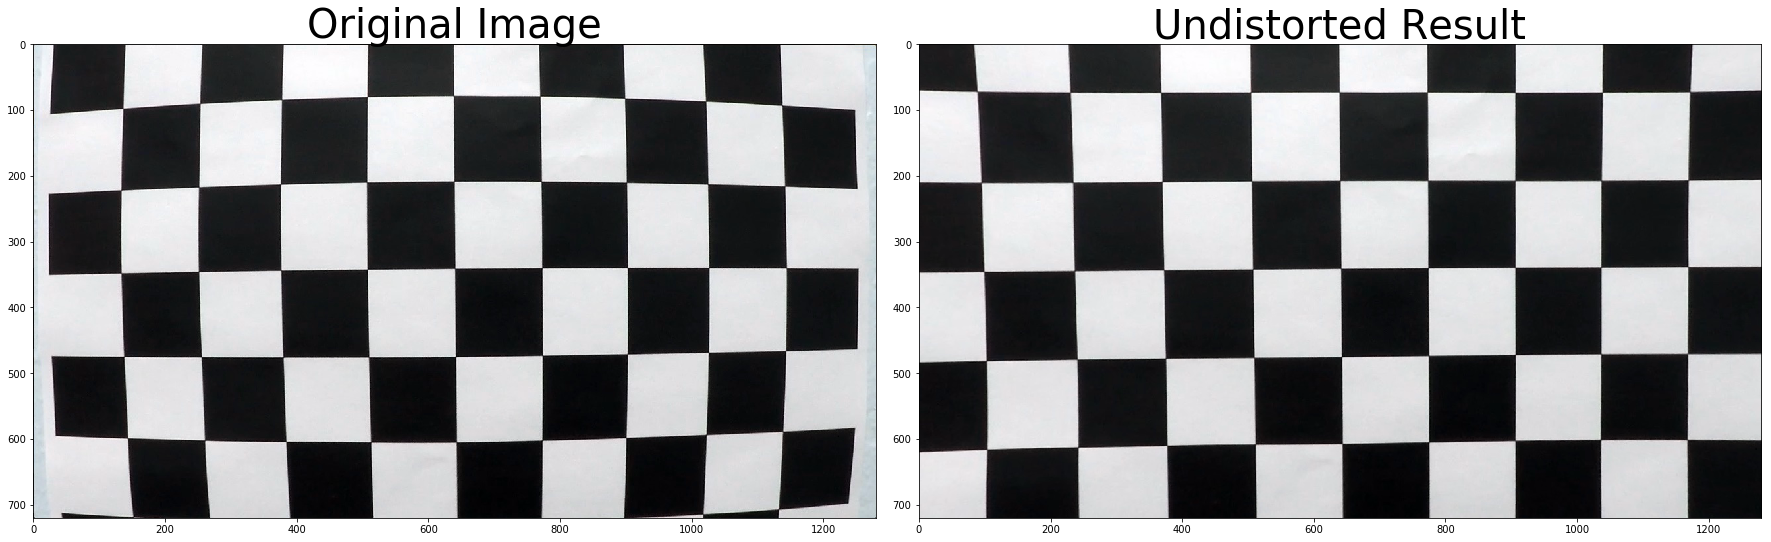

In [170]:
chess1 = image1
chess_undist = cv2.undistort(chess1,mtx,dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(chess1)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(chess_undist)
ax2.set_title('Undistorted Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define Thresholds
### Define Sobel Thresholds

In [173]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, x_thresh=(0, 255)):
    # Calculate directional gradient
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # # Apply threshold Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1
       
    return sx_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel_mag / np.max(sobel_mag))
    
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_dir = np.absolute(np.arctan2(sobelx, sobely))
#     scaled_sobel = np.uint8(255 * sobel_mag / np.max(soblel_mag))
    
    # Apply threshold
    dir_binary = np.zeros_like(sobel_dir)
    dir_binary[(sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1])] = 1
    
    return dir_binary

### Define Color Channel Thresholds

In [174]:
def color_threshold(img, clr_thresh = (0,255)):
    
    clr_binary = np.zeros_like(img)
    clr_binary[(img > clr_thresh[0]) & (img < clr_thresh[1])] = 1
    return clr_binary

# Define Region of Interest

In [175]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    l_x = 600
    r_x = 680
    u_y = 430
    d_xl = 100
    d_xr= 1200
    d_y = 720
    # Point(x,y) is using (x,y) as (column,row)
    vertices = np.array([[(l_x, u_y), (r_x, u_y), (d_xr, d_y), (d_xl, d_y)]],dtype = np.int32)

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

# Creation of Binary Images Using Thresholds

In [176]:
def pipeline(img):
    
    # if read image use cv2.imread, use BGR2GRAY, if use mpimg, use RGB2GRAY
    # the input image is in BGR
    img = np.copy(img)
    
#   Color-based feature of image: channels
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    clr_s_thresh = (80, 255)
    # s channel
    clr_binary = color_threshold(s_channel, clr_s_thresh)
    
# Shape-based feature: gradient
    # convert to gray color  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)  
    
    sobel_kernel = 3
    orient='x'
    sx_thresh = (20,80)
#     mag_thresh = (30,100)
#     dir_thresh = np.array([45,70])/180 * np.pi  # (35, 52) deg
    
    # Sobel x
    sx_binary = abs_sobel_thresh(gray, orient, sobel_kernel, sx_thresh)
    
    # Sobel mag
#     mag_binary= mag_threshold(gray, sobel_kernel, mag_thresh)
    # Sobel dir
#     dir_binary = dir_threshold(gray, sobel_kernel, dir_thresh)

# Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image.
    stack_bi = np.dstack((np.zeros_like(clr_binary), sx_binary, clr_binary)).astype('uint8') *255
    combined_bi = np.zeros_like(clr_binary)
    combined_bi[(sx_binary ==1) | (clr_binary ==1)] = 1
    
    # apply mask
    combined_bi_mask = region_of_interest(combined_bi) 
    
    return stack_bi, combined_bi_mask, sx_binary, clr_binary

# Undistort image and Apply thresholds

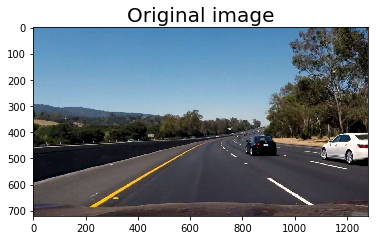

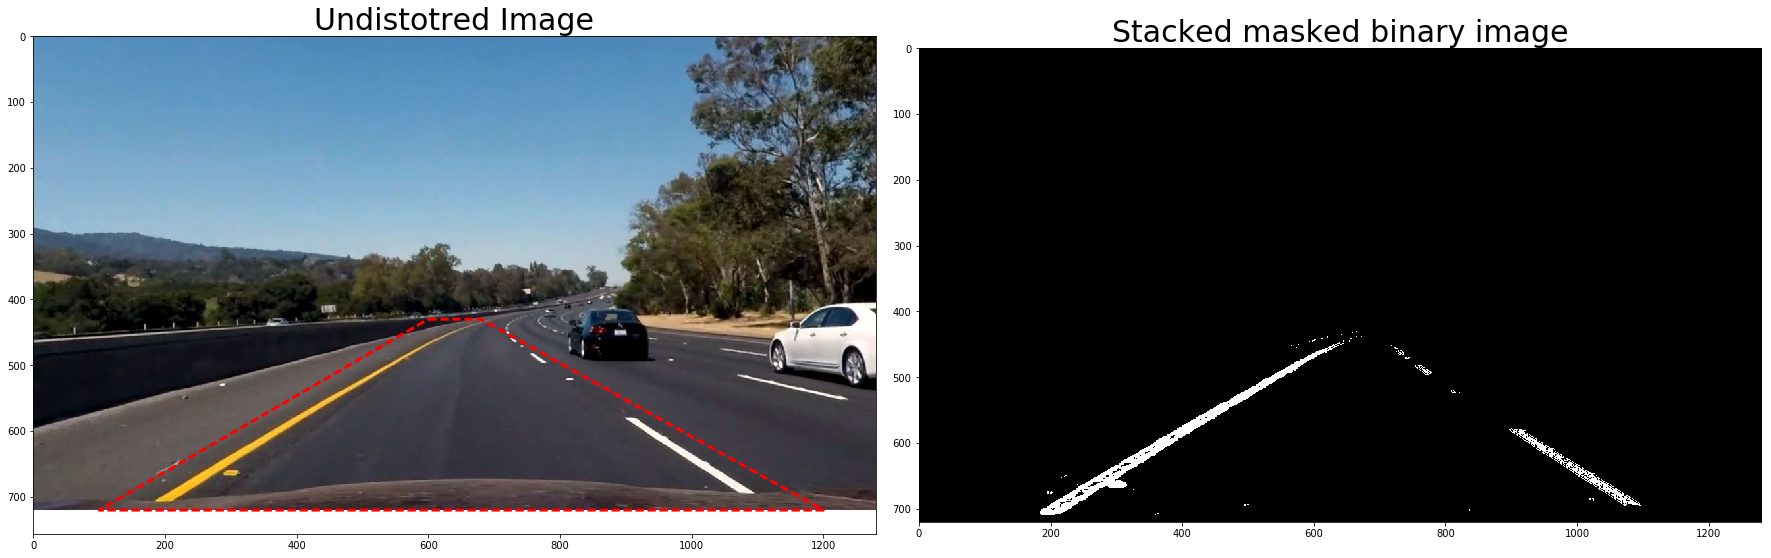

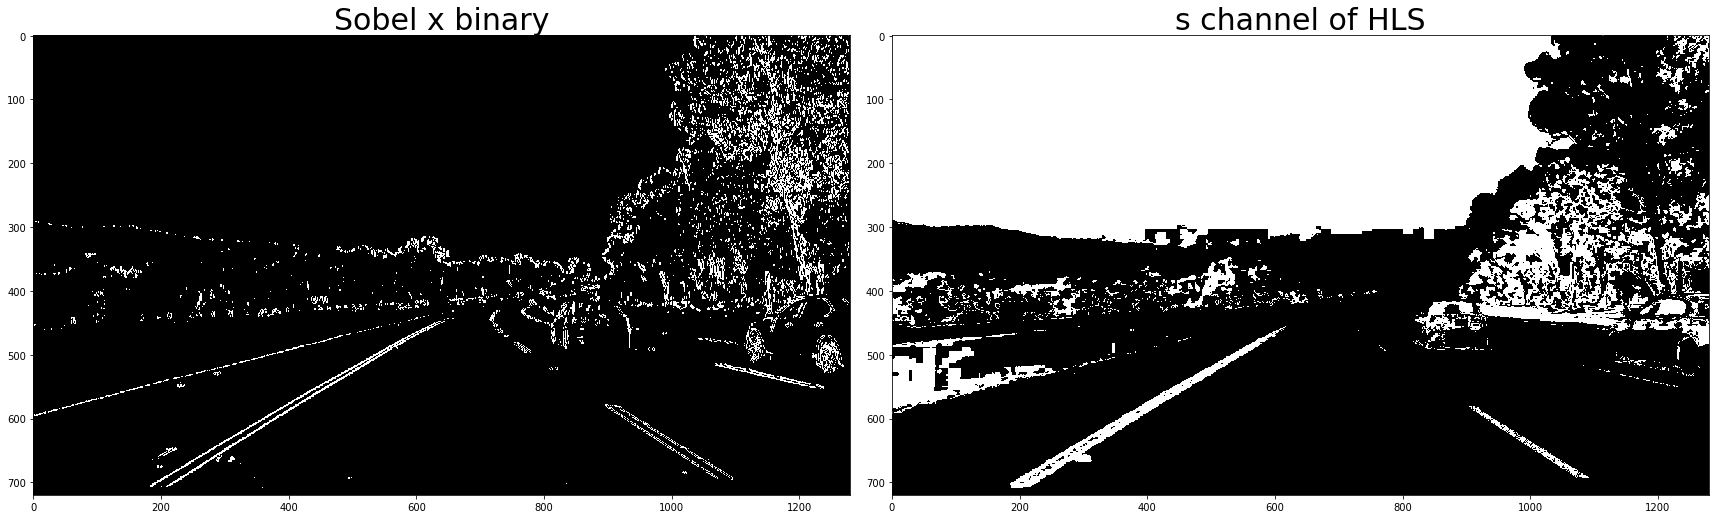

In [177]:
dirt_test = 'F:\Carnd codes\CarND-Advanced-Lane-Lines'
testImages = glob.glob(dirt_test + '\\test_images\*.jpg')
# dirt_test = 'F:\Carnd codes\CarND-Advanced-Lane-Lines'
# testImages = glob.glob(dirt_test + '\\test_images\\harder\*.jpg')
    
test1 = testImages[34]
test1 = cv2.imread(test1)
test1_undist = cv2.undistort(test1,mtx,dist, None, mtx)

stack_bi, combined_bi, sx_binary, clr_binary = pipeline(test1_undist)


l_x = 600
r_x = 680
u_y = 430
d_xl = 100
d_xr= 1200
d_y = 720
# Point(x,y) is using (x,y) as (column,row)
vertices = np.array([[l_x, u_y], [r_x, u_y], [d_xr, d_y], [d_xl, d_y],[l_x, u_y]],dtype = np.int32)

plt.figure()
plt.imshow(cv2.cvtColor(test1, cv2.COLOR_BGR2RGB))
plt.title('Original image', fontsize = 20)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(test1_undist, cv2.COLOR_BGR2RGB))
ax1.plot(vertices[:,0], vertices[:,1], 'r--', linewidth = 3)
ax1.set_title('Undistotred Image', fontsize=30)

ax2.imshow(combined_bi,cmap = 'gray')
ax2.set_title('Stacked masked binary image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
ax1.imshow(sx_binary, cmap='gray')
ax1.set_title('Sobel x binary', fontsize=30)
ax2.imshow(clr_binary,cmap='gray')
ax2.set_title('s channel of HLS', fontsize=30)

# f.savefig('Stacked_mask_bi')
# fsx.savefig('Sobel_x_bi')
# fclr.savefig('Color channel_s_bi')


# Perspective Transformation

In [178]:
image_size = (test1.shape[1], test1.shape[0])  # (1280, 720)
l_x = 600
r_x = 680
u_y = 448
d_xl = 230
d_xr= 1080
d_y = 700
# Point(x,y) is using (x,y) as (column,row)
src = np.float32([[l_x, u_y], [r_x, u_y], [d_xr, d_y], [d_xl, d_y]])
dst = np.float32([[330,0], [950, 0],[950, image_size[1]],[330, image_size[1]]])
vortex_src = np.float32([[l_x, u_y], [r_x, u_y], [d_xr, d_y], [d_xl, d_y],[l_x, u_y]])
vortex_dst = np.float32([[330,0], [950, 0],[950, image_size[1]],[330, image_size[1]],[330,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combined_bi, M, image_size, flags=cv2.INTER_LINEAR)
warped_test = cv2.warpPerspective(test1_undist, M, image_size, flags=cv2.INTER_LINEAR)

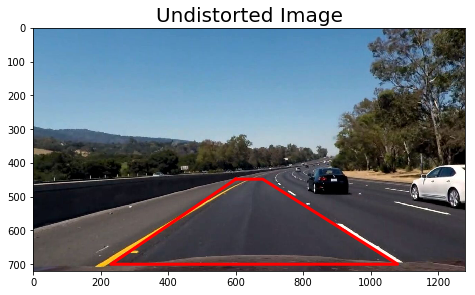

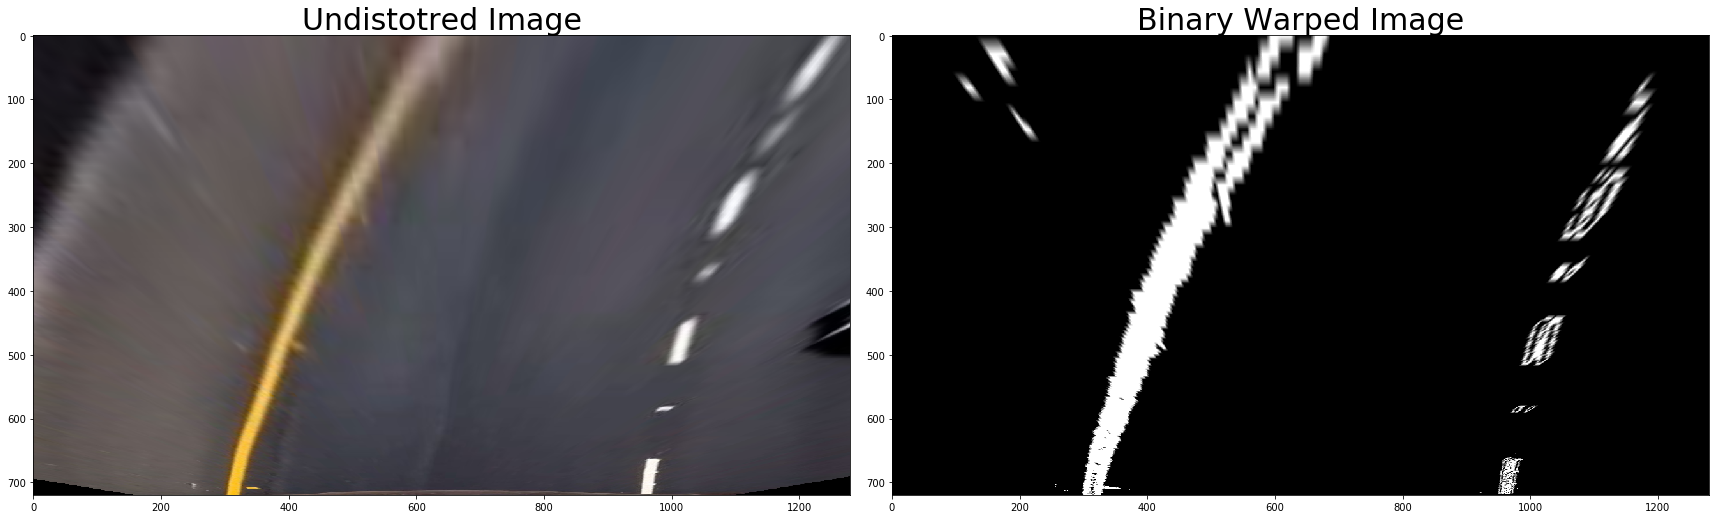

In [179]:
plt.figure()
plt.imshow(cv2.cvtColor(test1_undist, cv2.COLOR_BGR2RGB))
plt.plot(vortex_src[:,0],vortex_src[:,1],'r-',  linewidth = 3)
plt.title('Undistorted Image', fontsize = 20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()

ax1.imshow(cv2.cvtColor(warped_test, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistotred Image', fontsize=30)
ax2.imshow(binary_warped,cmap = 'gray')
ax2.set_title('Binary Warped Image',fontsize=30)
# f1.savefig('perspective tranformation_bi')

### Plot Transform Regions

In [180]:
# plt.imshow(test1_undist)
# # ax1.set_title('Original Image', fontsize=40)
# plt.plot(src[:,0],src[:,1],linestyle = '-.', color = 'r')
# plt.plot(dst[:,0],src[:,1],linestyle = '-.', color = 'b')

# Lane Line Detection

Offset -0.169142857143


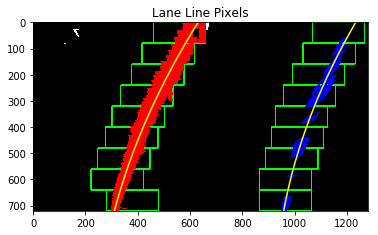

In [181]:
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# need to set np.uint8 to out_img to use (255, 0, 0) color map otherwise, should use (1,0,0)
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255 

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
xm_per_pix = 3.7/700 # meters per pixel in x dimension
offset = (midpoint - np.mean(np.array([leftx_base, rightx_base])) )* xm_per_pix
print('Offset', offset)
# Set height of windows
nwindows = 9
# Choose the number of sliding windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# plt.imshow(out_img)
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 

   
    #     # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each: np.polyfit(x,y): # y:independent var,  find fitted x(column) in this case
# why fitting for f(y), rather than f(x):
# because the lane lines in the warped image are near vertical and may have the same x value for more than one y value.
left_fit = np.polyfit(lefty, leftx, 2) 
right_fit = np.polyfit(righty, rightx, 2)

# plot fitting curve
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# cv2.imshow('out_img',out_img)

f = plt.figure()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Line Pixels')
# f.savefig('Lane Line Pixels')

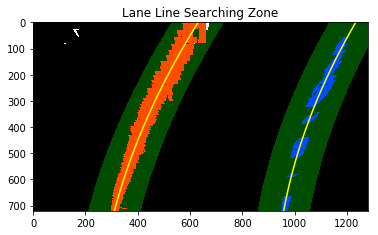

In [182]:
# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255 
window_img=np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
# vstack: Stack arrays in sequence vertically (row wise).
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))]) # left edge of left-line
# right edge of left line, flip upside down is to build a 'circle with left edge when stack them. 
# Otherwise, the points are all from up to down
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))]) 
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# overlap out_img(white shade image) and window_img(wide green shade), with: g(x) = (1 - a)img1 +b f_{1}img2 + c, a = 1, b = 0.3, c = 0
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
f2 = plt.figure()
plt.imshow(result)
# plt.imshow(binary_warped,cmap = 'gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Line Searching Zone')
# f2.savefig('Lane Line Searching Zone')

# Curvature Calculation

In [183]:
y_eval = np.max(ploty)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('left_curvature',left_curverad, 'm', 'right_curvature', right_curverad, 'm')
avg_radius_meters = np.mean([left_curverad, right_curverad])

left_curvature 659.263548626 m right_curvature 597.517435561 m


# Warped Back

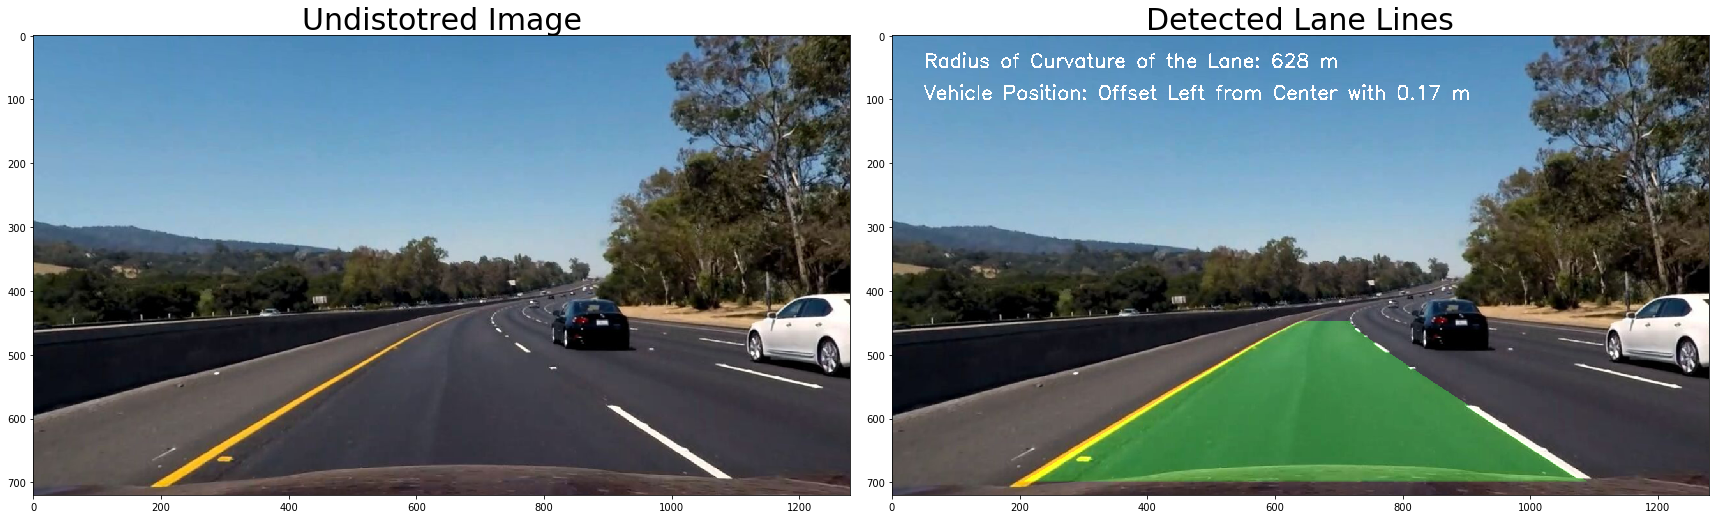

In [184]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, image_size) 
# Combine the result with the original image
result = cv2.addWeighted(test1_undist, 1, newwarp, 0.3, 0)

font = cv2.FONT_HERSHEY_SIMPLEX
text = "Radius of Curvature of the Lane: {:.0f} m".format(avg_radius_meters)
cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
if offset > 0:
    text = "Vehicle Position: Offset Right from Center with {:.2f} m".format(offset)
else:
    text = "Vehicle Position: Offset Left from Center with {:.2f} m".format(np.absolute(offset))
cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()

ax1.imshow(cv2.cvtColor(test1_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistotred Image', fontsize=30)
ax2.imshow((cv2.cvtColor(result, cv2.COLOR_BGR2RGB)))
ax2.set_title('Detected Lane Lines',fontsize=30)